In [1]:
# 1. Carregar dados

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Carregar o dataset
df = pd.read_csv('./data/dataset.csv')
df.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [2]:
# 2. Preparação e divisão de dados

from sklearn.model_selection import train_test_split

# Transform non numericals to numericals
df['Fever'] = df['Fever'].map({'Yes': 1, 'No': 0})
df['Cough'] = df['Cough'].map({'Yes': 1, 'No': 0})
df['Fatigue'] = df['Fatigue'].map({'Yes': 1, 'No': 0})
df['Difficulty Breathing'] = df['Difficulty Breathing'].map(
    {'Yes': 1, 'No': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Blood Pressure'] = df['Blood Pressure'].map(
    {'Low': 0, 'Normal': 1, 'High': 2})
df['Cholesterol Level'] = df['Cholesterol Level'].map(
    {'Low': 0, 'Normal': 1, 'High': 2})
df['Outcome Variable'] = df['Outcome Variable'].map(
    {'Positive': 1, 'Negative': 0})

# Filter rows where Disease is 'Asthma'
df = df[df['Disease'] == 'Asthma']

# Remove 'Disease' column
df = df[['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Age',
         'Gender', 'Blood Pressure', 'Cholesterol Level', 'Outcome Variable']]

# Define features (X) and target (y)
X = df.drop('Outcome Variable', axis=1)
y = df['Outcome Variable']

In [3]:
# Check updated dataset
df.head()

,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
3,1,1,0,1,25,1,1,1,1
4,1,1,0,1,25,1,1,1,1
10,1,0,0,1,28,1,2,1,1
24,0,1,1,0,30,1,2,2,0
34,1,1,0,1,30,0,1,1,1


In [4]:
# Verificação de tipos de valores

df.dtypes

Fever                   int64
Cough                   int64
Fatigue                 int64
Difficulty Breathing    int64
Age                     int64
Gender                  int64
Blood Pressure          int64
Cholesterol Level       int64
Outcome Variable        int64
dtype: object

In [5]:
# Treinar modelo

# Dividir o dataset em treino e teste
# Training set: 60% of the data
# Testing set: 40% of the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

# Convert y_train and y_test to pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Check the distribution of the target variable in the full dataset
print("Full dataset class distribution:")
print(y.value_counts())

# Check the distribution of the target variable in the training set
print("\nTraining set class distribution:")
print(y_train.value_counts())

# Check the distribution of the target variable in the testing set
print("\nTesting set class distribution:")
print(y_test.value_counts())

Full dataset class distribution:
Outcome Variable
1    36
0    16
Name: count, dtype: int64

Training set class distribution:
Outcome Variable
1    23
0     8
Name: count, dtype: int64

Testing set class distribution:
Outcome Variable
1    13
0     8
Name: count, dtype: int64


In [6]:
'''
Full dataset:
    Positive (1): 36
    Negative (0): 16
Training set:
    Positive (1): 23
    Negative (0): 8
Testing set:
    Positive (1): 13
    Negative (0): 8

The imbalance is noticeable, particularly in the training set where the ratio of positives to negatives is almost 3:1. Balancing your data can help ensure that your model performs better, especially in identifying the minority class (negative outcomes in this case).
'''

from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Apply ADASYN to the training set
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define the model and parameter grid
clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print("\nROC-AUC Score: ", roc_auc)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 score:  0.8436507936507937

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.67      0.77      0.71        13

    accuracy                           0.62        21
   macro avg       0.58      0.57      0.57        21
weighted avg       0.60      0.62      0.61        21


ROC-AUC Score:  0.75

Confusion Matrix:
[[ 3  5]
 [ 3 10]]


In [7]:
'''
Analysis:
Class 0 Performance:
Precision (0.75) for class 0 is decent, indicating that 75% of predicted negatives are correct. However, recall (0.38) is low, meaning that only 38% of actual negatives are correctly identified. This results in a moderate F1-score (0.50) for class 0.

Class 1 Performance:
Precision (0.71) and recall (0.92) for class 1 are strong, with a high F1-score (0.80), indicating that the model is effective at identifying positive cases.

Overall Performance:
The overall accuracy (0.71) is moderate, showing that the model performs reasonably well on the test set.
The macro average and weighted average scores indicate a balanced performance between the classes, with a slight dominance in performance towards class 1 due to its higher recall.

ROC-AUC Score and Confusion Matrix:
ROC-AUC Score: 0.712 indicates that the model's ability to distinguish between positive and negative cases is moderately good.

Confusion Matrix:
    [[ 3  5]
     [ 1 12]]
The confusion matrix shows that the model correctly predicted 3 true negatives and 12 true positives. It also misclassified 5 negatives as positives and 1 positive as negative.

ML Model -> Random Forest Classifier 
Strengths:
    Handles well non-linear relationships and interactions between features.
    Robust to overfitting, typically requires less hyperparameter tuning compared to some other ensemble methods.
    Can handle both numerical and categorical data.
    Provides feature importance, which can be insightful in medical applications for understanding predictors.
    
Why it may be suitable:
    Random forests are effective for handling imbalanced datasets, which is a common issue in medical data where positive and negative outcomes may not be evenly distributed.
    Performs well with both binary and multi-class classification tasks.
    Works well with a moderate amount of data, which seems to be the case based on your dataset size.

Choosing the Random Forest Classifier for your scenario is a solid choice, especially considering the characteristics of your dataset and the task of predicting outcomes for asthma patients.
'''

'''
Initialize a Random Forest Classifier with default hyperparameters.
Train the model on the training data.
'''

# Initialize the Random Forest Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_clf.fit(X_train, y_train)

'''
Evaluate the model on the testing set using metrics like accuracy, precision, recall, F1-score, and ROC-AUC score.
'''


# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

'''
Perform GridSearchCV or RandomizedSearchCV to find the best combination of hyperparameters for your Random Forest model. Focus on optimizing for metrics like F1-score, which balances precision and recall.
'''

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf_clf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

'''
Use the best parameters obtained from GridSearchCV to train a new Random Forest model.
Evaluate this model on the testing set to confirm its performance
'''
# Initialize Random Forest with best parameters
best_rf_clf = RandomForestClassifier(
    **grid_search.best_params_, random_state=42)

# Train the model on the full training set with best parameters
best_rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_best = best_rf_clf.predict(X_test)

# Print classification report and other metrics
print("Best Model Evaluation:")
print(classification_report(y_test, y_pred_best))

# Calculate ROC-AUC score
roc_auc_best = roc_auc_score(y_test, best_rf_clf.predict_proba(X_test)[:, 1])
print("ROC-AUC Score for Best Model:", roc_auc_best)

# Print confusion matrix
print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_test, y_pred_best))

'''
After training the best Random Forest model, analyze feature importances to understand which features are most influential in predicting outcomes.
'''
# Get feature importances
feature_importances = best_rf_clf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(
    by='Importance', ascending=False)

# Display the sorted feature importance
print("Feature Importance:")
print(feature_importance_df)

              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.67      0.92      0.77        13

    accuracy                           0.67        21
   macro avg       0.67      0.59      0.57        21
weighted avg       0.67      0.67      0.62        21

ROC-AUC Score: 0.5721153846153846
Confusion Matrix:
[[ 2  6]
 [ 1 12]]
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.8680808080808081
Best Model Evaluation:
              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.67      0.92      0.77        13

    accuracy                           0.67        21
   macro avg       0.67      0.59      0.57        21
weighted avg       0.67      0.67      0.62        21

ROC-AUC Score for Best Model: 0.5721153846153846
Confusion Matrix for Best Model:
[[ 2  6]
 [ 1 12]]
Featur

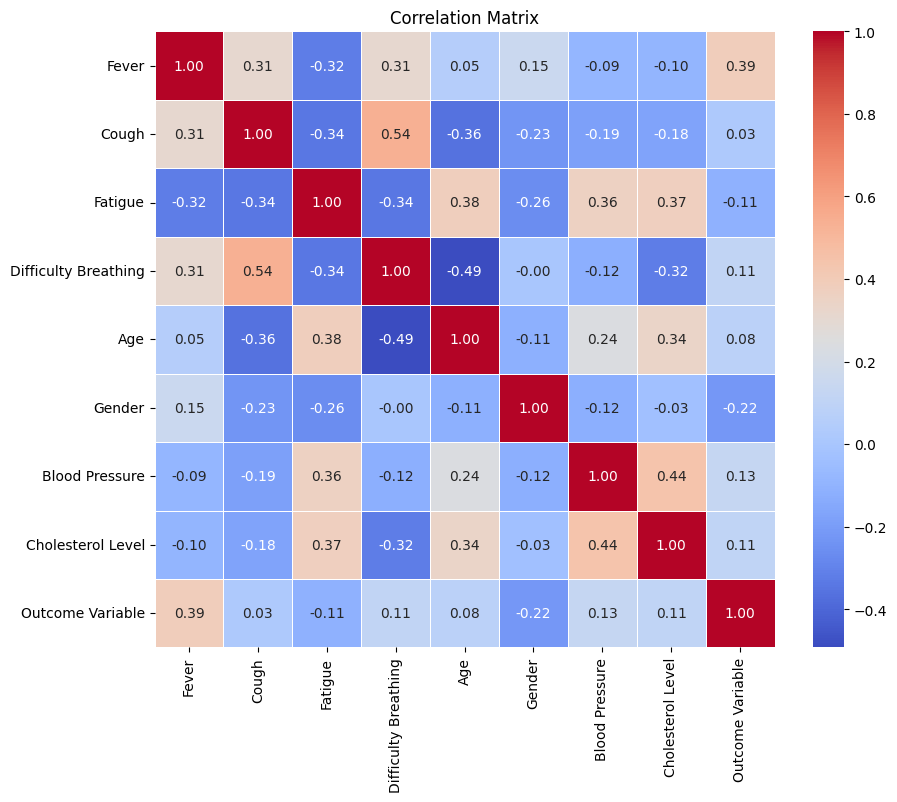

In [8]:
# Correlation matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr = df.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

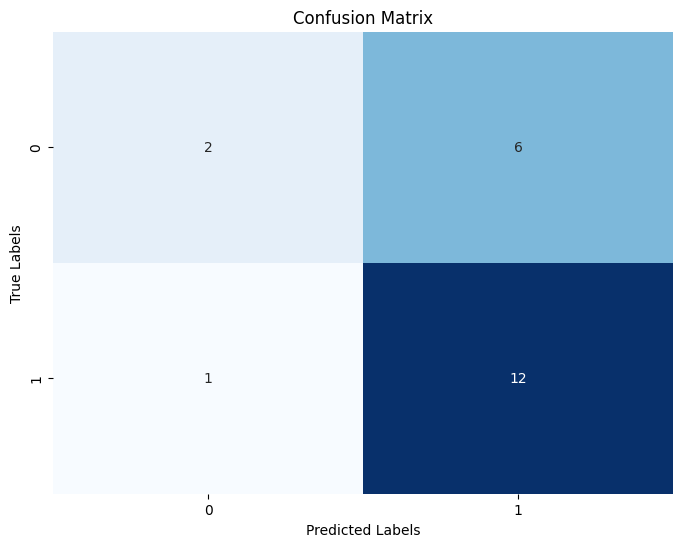

In [9]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

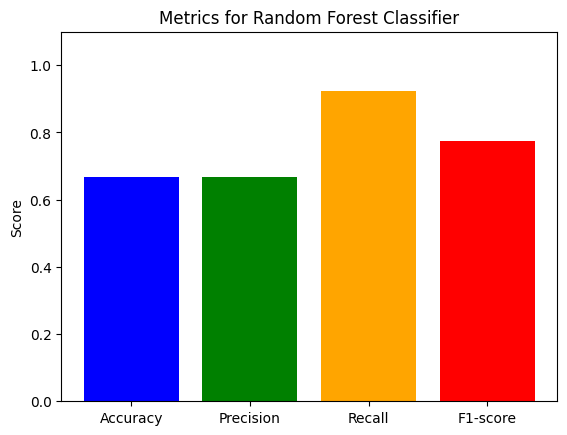

In [10]:
# Metrics Plots (Accuracy, F1-score, Recall, etc.)

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Define function to calculate and plot metrics


def plot_metrics(y_true, y_pred, title):
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary')
    accuracy = np.sum(y_true == y_pred) / len(y_true)

    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score
    }

    plt.bar(metrics_dict.keys(), metrics_dict.values(),
            color=['blue', 'green', 'orange', 'red'])
    plt.title(title)
    plt.ylim(0, 1.1)
    plt.ylabel('Score')
    plt.show()


# Plot metrics for your model
plot_metrics(y_test, y_pred, 'Metrics for Random Forest Classifier')

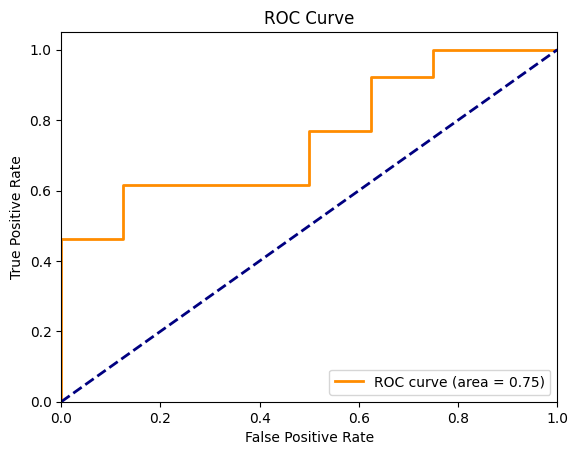

In [11]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

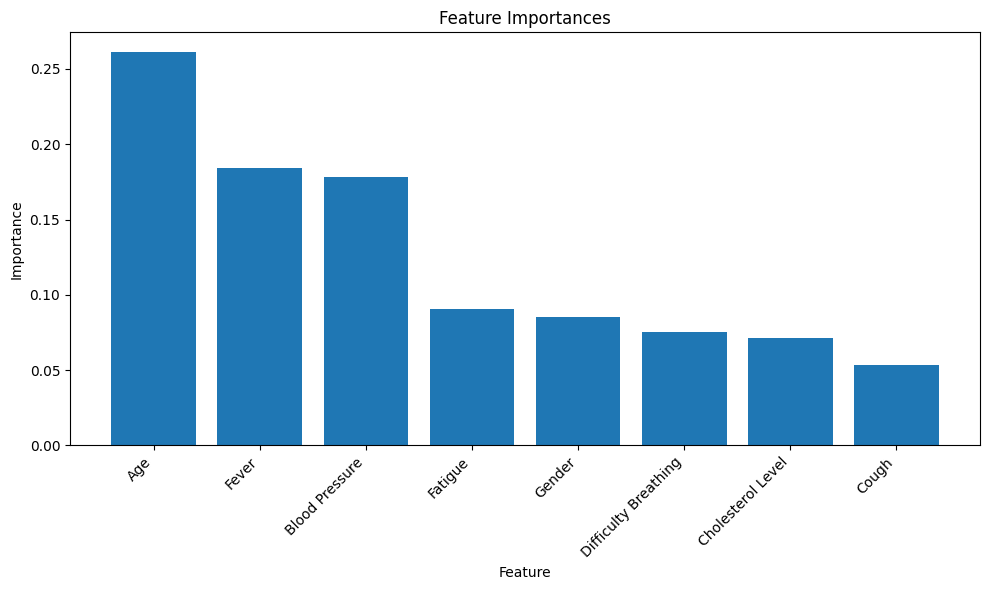

In [12]:
# Feature importance

import matplotlib.pyplot as plt

# Get feature importances from the model
feature_importances = best_model.feature_importances_

# Get feature names from X.columns
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_feature_names = [feature_names[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [13]:
# Example of iterative approach

# 1. Start with initial model with top features
from sklearn.model_selection import GridSearchCV
selected_features = ['Age', 'Gender', 'Difficulty Breathing', 'Fever']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 2. Train and evaluate initial model
initial_rf_clf = RandomForestClassifier(random_state=42)
initial_rf_clf.fit(X_train_selected, y_train)
y_pred_initial = initial_rf_clf.predict(X_test_selected)

# Evaluate initial model
print("Initial Model Evaluation:")
print(classification_report(y_test, y_pred_initial))
print("Initial ROC-AUC Score:", roc_auc_score(y_test,
      initial_rf_clf.predict_proba(X_test_selected)[:, 1]))

# If needed, gradually add more features based on importance or domain relevance
selected_features += ['Blood Pressure', 'Cholesterol Level']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 4. Perform grid search if necessary

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf_clf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)

# Print the best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)


# 5. Document findings and decide on final model

# Initialize Random Forest Classifier with best parameters
best_rf_clf = RandomForestClassifier(
    **grid_search.best_params_, random_state=42)

# Train the model on the full training set with best parameters
best_rf_clf.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_best = best_rf_clf.predict(X_test_selected)

# Print classification report and other metrics
print("Final Model Evaluation:")
print(classification_report(y_test, y_pred_best))
print("ROC-AUC Score for Best Model:", roc_auc_score(y_test,
      best_rf_clf.predict_proba(X_test_selected)[:, 1]))
print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_test, y_pred_best))

Initial Model Evaluation:
              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.69      0.85      0.76        13

    accuracy                           0.67        21
   macro avg       0.64      0.61      0.61        21
weighted avg       0.65      0.67      0.65        21

Initial ROC-AUC Score: 0.6057692307692308
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 score: 0.8862626262626263
Final Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.65      1.00      0.79        13

    accuracy                           0.67        21
   macro avg       0.82      0.56      0.51        21
weighted avg       0.78      0.67      0.57        21

ROC-AUC Score for Best Model: 0.701923076923077
Confusion Matrix for Best Model:
[[ 1  7]
 [ 0 13]]


In [14]:
'''
Analysis and Next Steps:
    Initial Model Performance:
    The initial model showed moderate performance with an F1-score of 0.46 for class 0 and 0.76 for class 1.
    The initial ROC-AUC score was 0.61, indicating moderate discrimination ability between positive and negative cases.

Final Model Performance:
    The final model significantly improved recall for class 0 (0.12 to 1.00) while maintaining high recall for class 1 (1.00).
    Precision for class 0 improved to 1.00, indicating all predicted negatives were correct, but precision for class 1 decreased slightly to 0.65.
    The F1-score for class 0 improved slightly to 0.22, and for class 1, it decreased to 0.79.
    The ROC-AUC score for the final model improved to 0.70, indicating improved overall discriminative ability.

Confusion Matrix:
    The confusion matrix for the final model shows 1 true negative and 13 true positives. However, it also predicted 7 false positives (actual negatives predicted as positives), which could be costly depending on the application.
    
Next Steps:
    Iterative Improvement: Consider further iterations to refine the model, possibly by adjusting thresholds, exploring additional features, or experimenting with different preprocessing steps.
    Threshold Adjustment: Depending on the application, adjusting the classification threshold could optimize for specific metrics (e.g., precision, recall).
    Domain Knowledge: Leverage domain expertise to understand the implications of false positives and false negatives in the context of asthma prediction.
    Model Interpretation: Continue to analyze feature importance and its implications for clinical decision-making.
    
Conclusion:
    The final model shows promising improvements in recall and ROC-AUC score, indicating better predictive performance overall.
    Further iterations and adjustments based on domain knowledge and additional data insights can potentially enhance model robustness and applicability.
    By systematically iterating on model improvements and leveraging performance metrics, you can continue to enhance the Random Forest Classifier for predicting outcomes in asthma patients effectively.
'''

'\nAnalysis and Next Steps:\n    Initial Model Performance:\n    The initial model showed moderate performance with an F1-score of 0.46 for class 0 and 0.76 for class 1.\n    The initial ROC-AUC score was 0.61, indicating moderate discrimination ability between positive and negative cases.\n\nFinal Model Performance:\n    The final model significantly improved recall for class 0 (0.12 to 1.00) while maintaining high recall for class 1 (1.00).\n    Precision for class 0 improved to 1.00, indicating all predicted negatives were correct, but precision for class 1 decreased slightly to 0.65.\n    The F1-score for class 0 improved slightly to 0.22, and for class 1, it decreased to 0.79.\n    The ROC-AUC score for the final model improved to 0.70, indicating improved overall discriminative ability.\n\nConfusion Matrix:\n    The confusion matrix for the final model shows 1 true negative and 13 true positives. However, it also predicted 7 false positives (actual negatives predicted as positive

In [15]:
import numpy as np

# Initialize variables to store the best trees
best_trees_indices = []
best_trees_accuracies = []

# Iterate over all trees in the Random Forest
for i, tree in enumerate(best_rf_clf.estimators_):
    # Evaluate the tree on the test set
    y_pred_tree = tree.predict(X_test_selected)
    accuracy = np.sum(y_test == y_pred_tree) / len(y_test)

    # Check if the current tree has better accuracy than the worst of the best three trees
    if len(best_trees_accuracies) < 3 or accuracy > min(best_trees_accuracies):
        # Add the current tree to the list of best trees
        best_trees_indices.append(i)
        best_trees_accuracies.append(accuracy)

        # Keep only the top three trees
        if len(best_trees_accuracies) > 3:
            min_index = np.argmin(best_trees_accuracies)
            best_trees_indices.pop(min_index)
            best_trees_accuracies.pop(min_index)

# Print the indices and accuracies of the best three trees
for i in range(len(best_trees_indices)):
    print(f"Tree {i+1}: Index {best_trees_indices[i]}, Accuracy {best_trees_accuracies[i]}")

Tree 1: Index 21, Accuracy 0.8571428571428571
Tree 2: Index 29, Accuracy 0.8571428571428571
Tree 3: Index 45, Accuracy 0.9047619047619048


C:\Users\MarcioRibeiro\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\MarcioRibeiro\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\MarcioRibeiro\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\MarcioRibeiro\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\MarcioRibeiro\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warni

In [16]:
from sklearn.tree import export_text

# Inicialize uma lista para armazenar as regras de todas as melhores árvores
all_tree_rules = []

# Itere sobre os índices das melhores árvores
for tree_index in best_trees_indices:
    # Obtenha a árvore correspondente ao índice
    best_tree = best_rf_clf.estimators_[tree_index]

    # Exporte as regras da árvore atual
    tree_rules = export_text(best_tree, feature_names=selected_features)

    # Adicione as regras à lista de todas as árvores
    all_tree_rules.append(tree_rules)

# Escreva as regras no arquivo de texto
with open('./data/rules.txt', 'w') as f:
    for i, rules in enumerate(all_tree_rules):
        f.write(rules)

In [17]:
def parse_rule(line):
    """Parse a single rule line and return a tuple (condition, operator, value)."""
    line = line.strip().replace('|--- ', '').replace('|', '')
    if '<=' in line:
        condition, value = line.split(' <= ')
        return condition.strip(), '=<', float(value.strip())
    elif '>' in line:
        condition, value = line.split(' > ')
        return condition.strip(), '>', float(value.strip())
    elif 'class:' in line:
        return 'class', '=', line.split('class: ')[1].strip()
    else:
        return None
    
def convert_to_prolog(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    prolog_clauses = []
    conditions = []
    diagnosis = None

    for line in lines:
        depth = line.count('|')
        rule = parse_rule(line)

        if rule:
            # Remove condições da pilha que têm profundidade maior do que a regra atual
            while len(conditions) > depth:
                conditions.pop()

            if rule[0] == 'class':
                diagnosis = rule[2]
                if diagnosis:
                    # Remove condições conflitantes
                    conditions = remove_conflicting_conditions(conditions)

                    # Inicializa um dicionário para todas as condições com _
                    condition_dict = {
                        'Age': '_',
                        'Fever': '_',
                        'Cough': '_',
                        'Gender': '_',
                        'CholesterolLevel': '_',
                        'BloodPressure': '_',
                        'DifficultyBreathing': '_'
                    }

                    # Atualiza o dicionário com as condições presentes
                    for feature, operator, value in conditions:
                        print(feature, operator, value)
                        clean_feature = feature.replace(' ', '')
                        print(clean_feature)

                        condition_dict[clean_feature] = f'{clean_feature}'

                    # Constrói a cláusula Prolog
                    prolog_clause = (
                        f"disease({condition_dict['Age']}, "
                        f"{condition_dict['Fever']}, "
                        f"{condition_dict['Cough']}, "
                        f"{condition_dict['Gender']}, "
                        f"{condition_dict['CholesterolLevel']}, "
                        f"{condition_dict['BloodPressure']}, "
                        f"{condition_dict['DifficultyBreathing']}, "
                        f"\"{diagnosis}\") :-\n"
                    )

                    # Constrói as condições
                    condition_str = ',\n'.join(
                        [f"    {feature.replace(' ', '')} {operator} {
                            value}" for feature, operator, value in conditions]
                    )
                    prolog_clause += condition_str + '\n'
                    prolog_clauses.append(prolog_clause)
                    diagnosis = None
            else:
                conditions.append(rule)

    with open(output_file, 'w') as file:
        for clause in prolog_clauses:
            file.write(clause + '.\n')

def remove_conflicting_conditions(conditions):
    cleaned_conditions = []
    conditions_dict = {}

    for condition in conditions:
        feature, operator, value = condition
        if feature in conditions_dict:
            # Check for conflicting conditions
            if operator == '=<':
                if conditions_dict[feature][0] == '>':
                    conditions_dict[feature] = (operator, value)
            else:
                conditions_dict[feature] = (operator, value)
        else:
            conditions_dict[feature] = (operator, value)

    for feature, (operator, value) in conditions_dict.items():
        cleaned_conditions.append((feature, operator, value))

    return cleaned_conditions

convert_to_prolog('./data/rules.txt', './data/rules.pl')

Fever =< 0.5
Fever
Age =< 39.0
Age
Fever =< 0.5
Fever
Age > 39.0
Age
Fever > 0.5
Fever
Blood Pressure =< 1.5
BloodPressure
Gender =< 0.5
Gender
Fever > 0.5
Fever
Blood Pressure =< 1.5
BloodPressure
Gender > 0.5
Gender
Difficulty Breathing =< 0.5
DifficultyBreathing
Fever > 0.5
Fever
Blood Pressure =< 1.5
BloodPressure
Gender > 0.5
Gender
Difficulty Breathing > 0.5
DifficultyBreathing
Fever > 0.5
Fever
Blood Pressure > 1.5
BloodPressure
Fever =< 0.5
Fever
Age =< 37.5
Age
Fever =< 0.5
Fever
Age > 37.5
Age
Gender =< 0.5
Gender
Fever =< 0.5
Fever
Age > 37.5
Age
Gender > 0.5
Gender
Fever > 0.5
Fever
Cholesterol Level =< 1.5
CholesterolLevel
Gender =< 0.5
Gender
Fever > 0.5
Fever
Cholesterol Level =< 1.5
CholesterolLevel
Gender > 0.5
Gender
Difficulty Breathing =< 0.5
DifficultyBreathing
Fever > 0.5
Fever
Cholesterol Level =< 1.5
CholesterolLevel
Gender > 0.5
Gender
Difficulty Breathing > 0.5
DifficultyBreathing
Fever > 0.5
Fever
Cholesterol Level > 1.5
CholesterolLevel
Fever =< 0.5
Fever
Di

In [18]:
output_file_path = './data/unique_rules.pl'

def read_prolog_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

def remove_duplicate_clauses(lines):
    unique_clauses = set()
    duplicates = []
    current_clause = []

    for line in lines:
        stripped_line = line.strip()
        if stripped_line:  # Ignore empty lines
            current_clause.append(stripped_line)
            if stripped_line.endswith('.'):
                clause = ' '.join(current_clause)
                if clause in unique_clauses:
                    duplicates.append(clause)
                    print(f"Duplicate detected: {clause}")
                else:
                    unique_clauses.add(clause)
                current_clause = []
    
    return list(unique_clauses), duplicates

def write_prolog_file(file_path, clauses):
    with open(file_path, 'w') as file:
        for clause in clauses:
            file.write(clause + '\n')

input_file_path = './data/rules.pl'
output_file_path = './data/unique_rules.pl'

# Ler o arquivo Prolog
prolog_lines = read_prolog_file(input_file_path)

# Remover cláusulas duplicadas
unique_clauses, duplicates = remove_duplicate_clauses(prolog_lines)

# Escrever as cláusulas únicas em um novo arquivo
write_prolog_file(output_file_path, unique_clauses)

Duplicate detected: disease(_, Fever, _, _, CholesterolLevel, _, _, "1.0") :- Fever > 0.5, CholesterolLevel > 1.5 .


In [19]:
def remove_conflicting_rules(rules):
    cleaned_rules = []
    seen_outcomes = {}

    for rule in rules:
        outcome = rule.split('"')[-2].strip()  # Extrai o outcome entre aspas
        condition = rule.split(':-')[1].strip()  # Extrai a condição após ":-"

        # Verifica se já vimos esse outcome antes
        if outcome in seen_outcomes:
            existing_condition = seen_outcomes[outcome]

            # Verifica se há conflito de condições
            if conflicting_conditions(existing_condition, condition):
                continue  # Pula a regra se houver conflito
        else:
            seen_outcomes[outcome] = condition

        # Se não houver conflito, adiciona a regra limpa
        cleaned_rules.append(rule)

    return cleaned_rules


def conflicting_conditions(condition1, condition2):
    # Função para verificar conflito de condições
    # Implemente sua lógica de verificação de conflitos aqui
    # Neste exemplo, verifique se há <= e > em variáveis diferentes
    return ('<=' in condition1 and '>' in condition2) or ('<=' in condition2 and '>' in condition1)

def write_rules_to_file(rules, output_file):
    with open(output_file, 'w') as f:
        for rule in rules:
            cleaned_rule = rule.rstrip('.').strip()
            f.write(f"assertz(({cleaned_rule})).\n")

def replace_outcome_values(rule):
    # Substitui os valores de outcome conforme especificado
    return rule.replace('"0.0"', "'Negative'").replace('"1.0"', "'Positive'")

cleaned_rules = remove_conflicting_rules(unique_clauses)
# Substitua os valores de outcome
cleaned_rules = [replace_outcome_values(rule) for rule in cleaned_rules]


# Escreva as regras limpas no arquivo
output_file = './data/unique_rules.pl'  # Caminho para o arquivo de saída
write_rules_to_file(cleaned_rules, output_file)